In [1]:
using Surrogates
using Plots
using Statistics
using Random
using DataFrames
using Distances
using LinearAlgebra
using PolyChaos
default()

┌ Warning: Package Surrogates does not have PolyChaos in its dependencies:
│ - If you have Surrogates checked out for development and have
│   added PolyChaos as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Surrogates
│ Loading PolyChaos into Surrogates from project dependency, future warnings for Surrogates are suppressed.
└ @ nothing nothing:910


In [2]:
import Pkg
Pkg.resolve()

  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [8]:
# Define the objective waterflow function (8 dimensions)
function f(x)
    r_w = x[1]
    r = x[2]
    T_u = x[3]
    H_u = x[4]
    T_l = x[5]
    H_l = x[6]
    L = x[7]
    K_w = x[8]
    log_val = log(r/r_w)
    return (2*pi*T_u*(H_u - H_l))/ ( log_val*(1 + (2*L*T_u/(log_val*r_w^2*K_w)) + T_u/T_l))
end


initial_n = 10000
d = 8
lb = [0.05,100,63070,990,63.1,700,1120,9855]
ub = [0.15,50000,115600,1110,116,820,1680,12045]
original_x = sample(initial_n,lb,ub,SobolSample())
original_y = f.(original_x);

In [4]:
# Implementing diversity
function calculate_variance(x, models)
    predictions = []
        for model in models
            prediction = model(x)
            append!(predictions, prediction)
        end
    return var(predictions, corrected=false)
end

function diversity_metric(prev_x, new_x, models, lambda = 0.5, mode=1)
    min_dist = Inf
    variance = calculate_variance(new_x, models)
    for point in prev_x
        new_dist = euclidean(point, new_x)
        if new_dist < min_dist
            min_dist = new_dist
        end
    end
    if mode == 0
        return (1 - lambda) * sqrt(variance) + lambda * min_dist
    elseif mode == 1
        return sqrt(variance) * min_dist
    end
end

diversity_metric (generic function with 3 methods)

In [5]:
function calculate_error(point, models, actual, mode="MSE")
    target = actual(point)
    errors = []
    for model in models
        prediction = model(point)
        append!(errors, abs(target - prediction))
    end
    println(errors)
    if mode == "MSE"
        return mean(errors.^2)
    end
    if mode == "max"
        return maximum(errors)
    end
end

calculate_error (generic function with 2 methods)

In [10]:
total_samples = 500
prev_points = copy(original_x)
y = copy(original_y)
test = sample(10000, lb, ub, GoldenSample())
y_true = f.(test)
error = Inf
while error > 2
    train = sample(total_samples, lb, ub, SobolSample())
    kriging_surrogate = Kriging(prev_points, y, lb, ub, p=[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, y, lb, ub)
    poly_model = PolynomialChaosSurrogate(prev_points, y, lb, ub)
    # Calculate the error
    
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    y_poly = poly_model.(test)
    mse_rad = norm(y_true - y_rad, 2) ^ 2 / length(test)
    mse_krig = norm(y_true - y_krig, 2) ^ 2 / length(test)
    mse_poly = norm(y_true - y_poly, 2) ^ 2 / length(test)
    error = (mse_rad + mse_krig + mse_poly) / 3
    println(error)
    
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(train)
        point = train[j]
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate, poly_model], 0, 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, train[[max_index]])
    println(train[[max_index]])
#     deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

1452.211229769321
[(0.14560546875, 30556.54296875, 68045.986328125, 1077.0703125, 114.60517578125, 717.2265625, 1245.234375, 12017.197265625)]


LoadError: InterruptException:

In [38]:
length(prev_points)

226

In [44]:
test_sample = sample(1000, lb, ub, SobolSample())
test_radial = RadialBasis(prev_points, f.(prev_points), lb, ub) 
# test_kriging = Kriging(prev_points, f.(prev_points), lb, ub, p=[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9])
norm(test_radial.(test_sample) - f.(test_sample), 2) ^ 2 / length(test_sample)

1.6197716137028628

In [40]:
norm(test_kriging.(test_sample) - f.(test_sample), 2)

1386.0934794478655

In [13]:
size(prev_points)

(159,)

In [19]:
train_radial = RadialBasis(original_x, original_y, lb, ub)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{Tuple{Float64, Float64, Float64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Transpose{Float64, Vector{Float64}}, Float64, Bool}) (generic function with 1 method)

In [11]:
norm(train_radial.(test) - f.(test), 2) / length(test)

3.580590718122096

In [57]:
println(size(prev_points))

(51,)


In [93]:
n_test = 200
x_test = sample(n_test,lb,ub,GoldenSample());
y_true = f.(x_test);
my_rad = RadialBasis(prev_points, y, lb, ub)
my_krig = Kriging(prev_points, y, lb, ub, p=[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9])
y_rad = my_rad.(x_test)
y_krig = my_krig.(x_test);

In [94]:
mse_rad = norm(y_true - y_rad,2)/n_test
mse_krig = norm(y_true - y_krig,2)/n_test
print("MSE RadialBasis: $mse_rad    ")
print("MSE Kriging: $mse_krig    ")

MSE RadialBasis: 3.332413447008887    MSE Kriging: 3.257493137405216    

In [11]:
function f(x)
    h = x[1]
    l = x[2]
    t = x[3]
    a = 6000/(sqrt(2)*h*l)
    b = (6000*(14+0.5*l)*sqrt(0.25*(l^2+(h+t)^2)))/(2*(0.707*h*l*(l^2/12 + 0.25*(h+t)^2)))
    return (sqrt(a^2+b^2 + l*a*b))/(sqrt(0.25*(l^2+(h+t)^2)))
end

f (generic function with 1 method)

In [29]:
initial_n = 100     # number of initial sampling points

lb = [0.125,5.0,5.0]
ub = [1.,10.,10.]
original_x = sample(initial_n,lb,ub,SobolSample())   # sample the initial points using sobolsample

# push!(x, (0.125,5.0,5.0))
# push!(x, (1.,10.,10.))
original_y = f.(original_x);

In [31]:
total_samples = 5000
prev_points = copy(original_x)
y = copy(original_y)
test = sample(10000, lb, ub, GoldenSample())
y_true = f.(test)
error = Inf
test_errors = []
while error > 100000
    train = sample(total_samples, lb, ub, SobolSample())
    kriging_surrogate = Kriging(prev_points, y, lb, ub, p=[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, y, lb, ub)
    poly_model = PolynomialChaosSurrogate(prev_points, y, lb, ub)
    # Calculate the error
    
    y_rad = my_radial_basis.(test)
    y_krig = kriging_surrogate.(test)
    y_poly = poly_model.(test)
    mse_rad = norm(y_true - y_rad, 2) ^ 2 / length(test)
    mse_krig = norm(y_true - y_krig, 2) ^ 2 / length(test)
    mse_poly = norm(y_true - y_poly, 2) ^ 2 / length(test)
    error = (mse_rad + mse_krig + mse_poly) / 3
    println(error)
    append!(test_errors, error)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:length(train)
        point = train[j]
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate, poly_model], 0, 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, train[[max_index]])
    println(train[[max_index]])
#     deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

495190.3488430563
[(0.1597137451171875, 5.1983642578125, 5.1568603515625)]
445842.1903182045
[(0.1364288330078125, 9.6429443359375, 5.0433349609375)]
438856.18610065867
[(0.1381378173828125, 7.1331787109375, 7.0843505859375)]
408005.8446255294
[(0.1889801025390625, 5.0457763671875, 6.5057373046875)]
397077.80152018927
[(0.7115020751953125, 5.1165771484375, 9.9700927734375)]
384738.3620499167
[(0.9813613891601562, 9.81964111328125, 9.96978759765625)]
377554.9875046746
[(0.4790802001953125, 5.0384521484375, 5.2044677734375)]
334397.69719813013
[(0.1334381103515625, 8.4783935546875, 5.8074951171875)]
330470.7407393756
[(0.9898529052734375, 5.6939697265625, 6.2774658203125)]
327921.4514629063
[(0.1340789794921875, 5.0518798828125, 7.6666259765625)]
344238.01502709114
[(0.16190338134765625, 5.74249267578125, 9.11529541015625)]
331440.8435554085
[(0.1458282470703125, 5.5950927734375, 5.1556396484375)]
346672.9443822282
[(0.9847259521484375, 8.8482666015625, 9.9200439453125)]
345711.451101570

325491.25538037677
[(0.5102691650390625, 8.9129638671875, 6.9354248046875)]
324077.75376910827
[(0.4540863037109375, 5.7867431640625, 8.6846923828125)]
321946.40858634625
[(0.1477508544921875, 9.0362548828125, 9.1510009765625)]
322899.1943199376
[(0.9981842041015625, 5.4901123046875, 9.5379638671875)]
323108.1501704885
[(0.5260772705078125, 5.5413818359375, 9.3792724609375)]
321383.13496672333
[(0.6053848266601562, 5.01495361328125, 5.55572509765625)]
320470.79833174846
[(0.6011123657226562, 9.24835205078125, 9.98443603515625)]
319474.81989093946
[(0.3635101318359375, 6.1676025390625, 5.8819580078125)]
316399.2814682832
[(0.9986114501953125, 9.8822021484375, 9.7357177734375)]
318154.31217932556
[(0.3874359130859375, 6.4996337890625, 5.0030517578125)]
311801.04551482433
[(0.9514007568359375, 5.7769775390625, 5.0225830078125)]
311320.5112919403
[(0.9125213623046875, 7.1661376953125, 5.0152587890625)]
310594.64235134836
[(0.2707977294921875, 5.8331298828125, 5.0103759765625)]
305200.62330

LoadError: InterruptException:

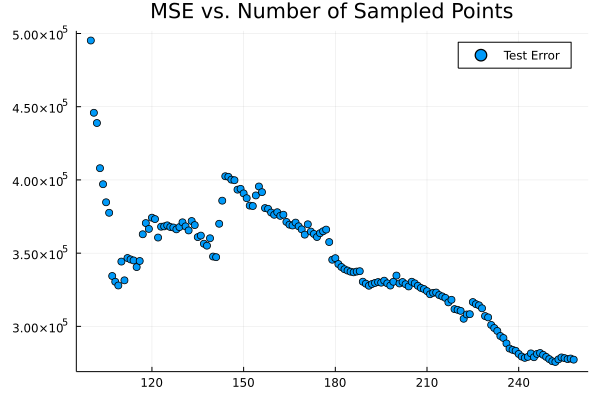

In [35]:
plot(initial_n:initial_n + length(test_errors) - 1, test_errors, seriestype=:scatter, 
    label="Test Error", title="MSE vs. Number of Sampled Points")

In [33]:
length(prev_points)

258